In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False
import matplotlib as mpl
import matplotlib.font_manager as fm

# 폰트 파일 경로 지정
font_path = '/content/drive/MyDrive/font/NanumGothic.ttf'

# 폰트 등록 및 matplotlib 설정
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [ ]:
import pandas as pd
from google.colab import drive, files

# 1. Google Drive 마운트
drive.mount('/content/drive')

# 2. 파일 경로 설정 (사용자 지정 경로)
data_root = '/content/drive/MyDrive/Colab Notebooks/final_project/final_sampling'
file_path = f'{data_root}/train_12.parquet'

# # 3. Parquet 파일 불러오기
# df = pd.read_parquet(file_path)

# # 4. CSV로 저장 (엑셀용 UTF-8-sig 인코딩)
# csv_filename = 'train_12.csv'
# df.to_csv(csv_filename, index=False, encoding='utf-8-sig')

# # 5. 로컬로 다운로드
# files.download(csv_filename)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 파일 경로 설정
data_root = '/content/drive/MyDrive/Colab Notebooks/final_project/final_sampling'

X_path = f'{data_root}/train_12.parquet'
y_path = f'{data_root}/segment_12.parquet'

# 데이터 불러오기
X_df = pd.read_parquet(X_path)
y_df = pd.read_parquet(y_path)

# ID 기준으로 병합
df = pd.merge(X_df, y_df, on='ID', how='inner')

# 확인
print(df.shape)
df.head()

(400000, 313)


,기준년월,ID,이용금액_R3M_신용체크,입회경과개월수_신용,_1순위카드이용금액,회원여부_이용가능_카드론,이용거절여부_카드론,최종카드발급경과월,이용금액_R3M_신용,_1순위카드이용건수,...,변동률_잔액_CA_B1M,혜택수혜율_R3M,혜택수혜율_B0M,잔액_한도소진율,증감율_카드론_분기,증감율_일시불_분기,증감율_체크_분기,증감율_카드론_전월,변동률_RV평잔,Segment
0,201812,TRAIN_000000,-454,71,3027,0,0,27,-454,25,...,0.000000,0.878859,1.398627,3.407027,0.143423,-0.609648,0.086480,0.048726,0.321733,D
1,201812,TRAIN_000001,7089,16,7259,1,0,23,7089,31,...,0.000000,0.000000,0.000000,5.196375,0.143423,-0.597498,0.086480,0.048726,0.214949,E
2,201812,TRAIN_000002,27336,128,26968,0,0,25,27336,52,...,-0.115879,0.187467,-1.198788,4.332080,0.143423,-0.154887,0.086480,0.048726,-2.839702,C
3,201812,TRAIN_000003,4270,31,4807,0,0,22,4270,27,...,0.000000,0.781401,1.282494,6.248569,0.143423,0.593422,0.086480,0.048726,0.321733,D
4,201812,TRAIN_000004,9385,6,3989,1,0,20,7387,-2,...,0.000000,0.762016,0.986860,-2.056257,0.143423,4.964378,-0.654283,0.048726,0.321733,E


In [ ]:
# 타겟 변수와 피처 나누기
target_col = 'Segment'
X = df.drop(columns=[target_col])
y = df[target_col]

In [ ]:
# Label Encoder
from sklearn.preprocessing import LabelEncoder

# 타겟 값 y 인코딩
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# 타겟 값 X 인코딩
cat_cols = X.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col].astype(str))

In [ ]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# 스케일링 – XGBoost는 꼭 필요하진 않지만 해도 무방
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# XGBoost 모델 학습
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:27:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.16      0.24        32
           1       0.00      0.00      0.00         5
           2       0.72      0.59      0.65      4253
           3       0.73      0.69      0.71     11642
           4       0.95      0.97      0.96     64068

    accuracy                           0.91     80000
   macro avg       0.58      0.48      0.51     80000
weighted avg       0.91      0.91      0.91     80000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Segment별 성능 분석
A: 일부 예측, 대부분 실패
B: 모델이 존재조차 모름
C: 중간 정도 성능
D: 안정적인 성능
E: 매우 우수, 모델이 해당 클래스에 최적화됨
=> 심각한 클래스 불균형

macro avg (모든 클래스 평균)

precision: 0.58 / recall: 0.48 / f1-score: 0.51
→ Segment 0, 1의 성능이 전체 macro 평균을 끌어내리고 있음

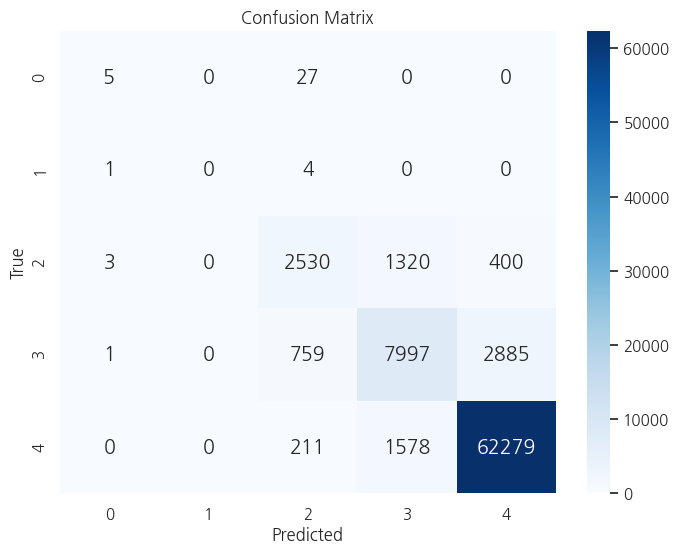

In [ ]:
# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

C.M
- A 대부분을 C로 착각
- B 5개 중 4개를 C로 착각
- C, D 간 혼동
- D, E 경계 모호
- E 거의 완벽하게 예측

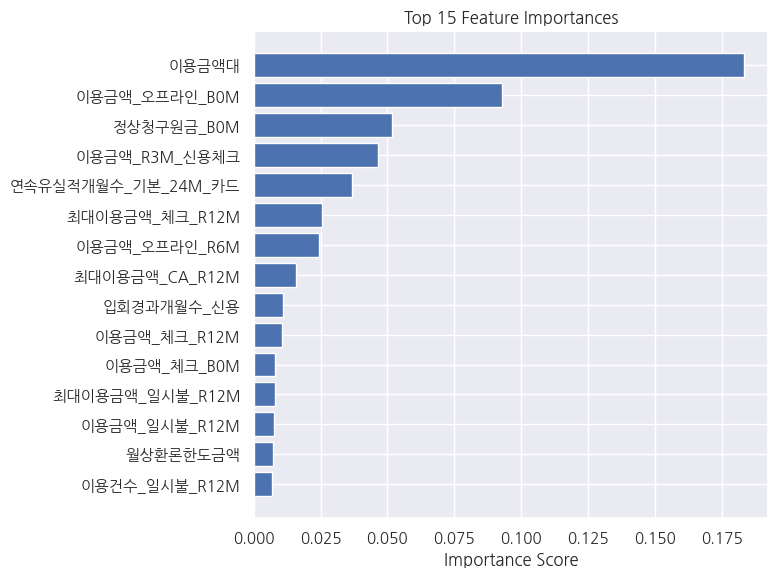

In [ ]:
# 피처 중요도 시각화
importances = model.feature_importances_
indices = np.argsort(importances)[-15:]  # 상위 15개

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

피처 중요도 분석
1. 이용금액대(압도적 중요도)
2. 이용금액_오프라인_B0M
3. 정상청구원금_B0M
4. 이용금액_R3M_신용체크
5. 연속유실적개월수_기본_24M_카드

→ 이 변수들이 소비 규모, 최근 이용 이력, 지속 사용 여부 등을 잘 반영하고 있음.
그러나 소수 클래스 구분에는 부족할 가능성이 높음.

SMOTE 오버샘플링으로 소수 클래스(Segment A, B) 증강

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 타겟 라벨 인코딩 (Segment: 'A'~'E' → 0~4)
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 2. 범주형 변수 인코딩 (이미 적용된 경우 생략 가능)
cat_cols = X.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# 3. 데이터 분할 (train/test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# 4. 스케일링 (선택 – 이미 하신 경우 생략 가능)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 5. SMOTE 적용 (Segment 0 → 1000개, Segment 1 → 1000개까지만 증강)
smote = SMOTE(sampling_strategy={0: 1000, 1: 1000}, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# 확인
print("After selective SMOTE:", np.bincount(y_train_resampled))
print("Before SMOTE:", np.bincount(y_train))

After selective SMOTE: [  1000   1000  17012  46565 256274]
Before SMOTE: [   130     19  17012  46565 256274]


In [ ]:
# 10/0

In [ ]:
# 6. XGBoost 모델 학습
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_resampled, y_train_resampled)

# 7. 예측 및 평가
y_pred = model.predict(X_test_scaled)
target_names = [str(cls) for cls in le_y.classes_]
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=target_names))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:31:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.28      0.35        32
           1       0.33      0.20      0.25         5
           2       0.71      0.59      0.65      4253
           3       0.73      0.68      0.71     11642
           4       0.95      0.97      0.96     64068

    accuracy                           0.91     80000
   macro avg       0.64      0.55      0.58     80000
weighted avg       0.91      0.91      0.91     80000



- Segment 0, 1의 recall 상승
→ 기존에는 Segment 1이 완전히 무시되었지만, 이제는 20% 정도라도 잡힘

- 정확도(accuracy)는 그대로 91% 유지

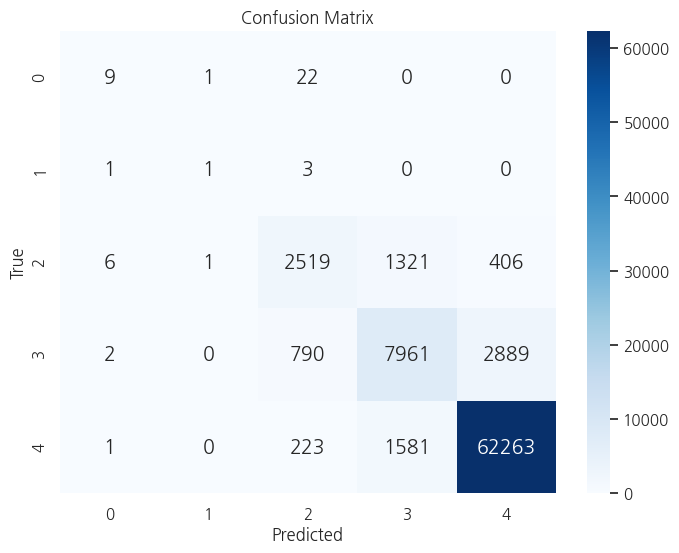

In [ ]:
# 8. 혼동 행렬 시각화
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

- Segment 2~4는 여전히 경계가 조금 모호하므로, 파생변수 추가나 하이퍼파라미터 튜닝으로 더 다듬자

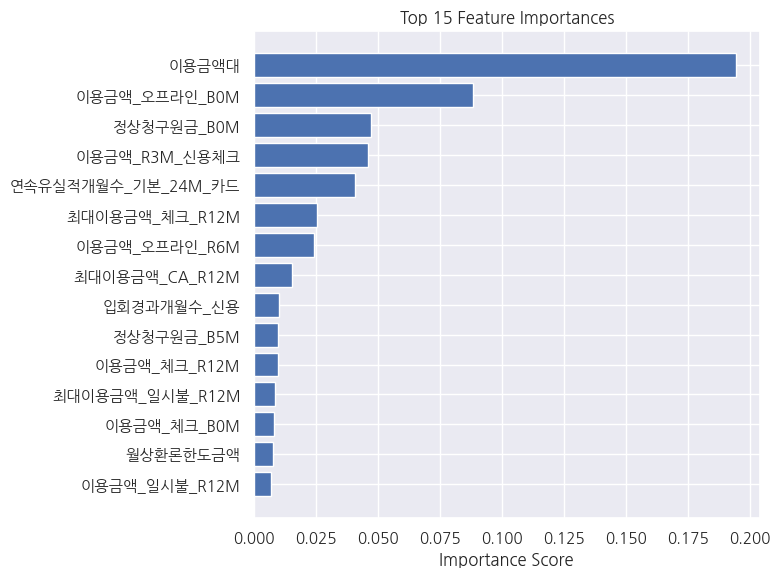

In [ ]:
# 9. 피처 중요도 시각화
importances = model.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

상위 변수는 여전히 일관되게 소비 금액 중심:

1. 이용금액대
2. 이용금액_오프라인_B0M
3. 정상청구원금_B0M
4. 이용금액_R3M_신용체크
5. 연속유실적개월수_기본_24M_카드

추가로 등장한 변수:
- 정상청구원금_B5M
- 월상환론한도금액

→ 신용 관련 변수들이 세그먼트 구분에 유의미하게 작용 중

In [ ]:
# 10/0

#하이퍼파라미터 튜닝

1. 가벼운 GridSearch(모든 조합을 무식하게 다 해보는)

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': [100],         # 트리 수 고정
    'max_depth': [3, 5],           # 깊이만 바꿔보기
    'learning_rate': [0.05, 0.1]   # 학습률 2개
}

grid = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1  # 병렬 처리
)

grid.fit(X_train_resampled, y_train_resampled)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


KeyboardInterrupt: 

2. 최적 파라미터 적용 후 재학습 및 평가

In [ ]:
best_model = XGBClassifier(
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
best_model.fit(X_train_resampled, y_train_resampled)

y_pred = best_model.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=[str(cls) for cls in le_y.classes_]))


ㅇ

In [ ]:
!pip install optuna

Optuna 튜닝(XGBoost)

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
    }

    model = XGBClassifier(**param, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    score = cross_val_score(model, X_train_resampled, y_train_resampled, scoring='accuracy', cv=3).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

print("Best params:", study.best_params_)

In [ ]:
# n_trials = 10으로 하자. study.best_params_ 출력 확인하기, 그 파라미터로 재학습+결과 확

VotingClassifier (XGBoost + RF + LGBM)

In [ ]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier

# 각각 최적 파라미터 적용
xgb = XGBClassifier(
    learning_rate=0.1, max_depth=5, n_estimators=100,
    use_label_encoder=False, eval_metric='mlogloss', random_state=42
)

rf = RandomForestClassifier(
    n_estimators=200, max_depth=10, random_state=42
)

lgbm = LGBMClassifier(
    learning_rate=0.1, max_depth=5, n_estimators=100, random_state=42
)

# VotingClassifier 정의 (soft voting = 확률 기반)
voting_model = VotingClassifier(
    estimators=[('xgb', xgb), ('rf', rf), ('lgbm', lgbm)],
    voting='soft'
)

# 학습 및 예측
voting_model.fit(X_train_resampled, y_train_resampled)
y_pred_vote = voting_model.predict(X_test_scaled)

# 평가
from sklearn.metrics import classification_report
print("Voting Classification Report:\n",
      classification_report(y_test, y_pred_vote, target_names=[str(c) for c in le_y.classes_]))


- XGBoost 단독보다 나은지 비교

#앙상블 학습/Voting

In [ ]:
# from sklearn.ensemble import VotingClassifier
# from sklearn.ensemble import RandomForestClassifier
# from lightgbm import LGBMClassifier

# vote_model = VotingClassifier(estimators=[
#     ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
#     ('rf', RandomForestClassifier()),
#     ('lgbm', LGBMClassifier())
# ], voting='soft')

# vote_model.fit(X_train_resampled, y_train_resampled)
